# General libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
from pymatgen.core import periodic_table
import pymatgen.io.cif as cif
import pymatgen.analysis.ewald as ewald

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Dataset normalization

In [75]:
df = pd.read_csv('Var_01.csv')
df.sample(2)

# all need is POSCAR as input for future engineernig
df.drop(['energy_per_atom', 'formation_energy_per_atom', 'volume', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 
 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 
 'icsd_id', 'icsd_ids',  'total_magnetization', 'material_id', 'oxide_type', 'tags', 'piezo', 'diel', 'full_formula'], axis='columns', inplace=True)
df.dropna(inplace=True)

In [76]:
# extract bulk moduli
df['bulk'] = df.elasticity.apply(lambda x: eval(x)['K_VRH'])
df

,energy,cif,elasticity,bulk
2,-15.580602,# generated using pymatgen\r\ndata_FeAg3\r\n_s...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0
4,-11.293552,# generated using pymatgen\r\ndata_AlFe\r\n_sy...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0
5,-41.981392,# generated using pymatgen\r\ndata_AlFe2\r\n_s...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0
7,-64.628769,# generated using pymatgen\r\ndata_Al6Fe\r\n_s...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0
9,-40.645991,# generated using pymatgen\r\ndata_Al3Fe\r\n_s...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0
...,...,...,...,...
550,-49.071885,# generated using pymatgen\r\ndata_YFe5\r\n_sy...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0
563,-25.278117,# generated using pymatgen\r\ndata_Zn13Fe\r\n_...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0
566,-51.810017,# generated using pymatgen\r\ndata_ZrFe2\r\n_s...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0
568,-51.939510,# generated using pymatgen\r\ndata_Zr2Fe\r\n_s...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0


In [77]:
# predicted value
pred_val = 'bulk'

---

# Data processing

In [78]:
def get_elem_props(elem):
    elem_props = {}
    elem_props['Z'] = periodic_table.Element(elem).Z
    elem_props['X'] = periodic_table.Element(elem).X
    elem_props['oxidation_states'] = periodic_table.Element(elem).oxidation_states
    elem_props['row'] = periodic_table.Element(elem).row
    elem_props['group'] = periodic_table.Element(elem).group
    elem_props['atomic_mass'] = periodic_table.Element(elem).atomic_mass
    elem_props['atomic_radius'] = periodic_table.Element(elem).atomic_radius
    elem_props['electrical_resistivity'] = periodic_table.Element(elem).electrical_resistivity
    elem_props['velocity_of_sound'] = periodic_table.Element(elem).velocity_of_sound
    elem_props['molar_volume'] = periodic_table.Element(elem).density_of_solid
    elem_props['thermal_conductivity'] = periodic_table.Element(elem).thermal_conductivity
    elem_props['melting_point'] = periodic_table.Element(elem).melting_point
    elem_props['average_ionic_radius'] = periodic_table.Element(elem).average_ionic_radius
    elem_props['average_cationic_radius'] = periodic_table.Element(elem).average_cationic_radius
    elem_props['average_anionic_radius'] = periodic_table.Element(elem).average_anionic_radius

    return elem_props

# Functions for the futures extracting

Extract pymatgen structure object from cif file as string

In [79]:
def get_struct(file_cif):
    imported_cif = cif.CifParser.from_string(file_cif) #; print(imported_cif)
    struct = imported_cif.get_structures()[0] #; print(struct)
    return struct

Function on Ewald summation as the convolutional layer for crystalline graph

$ E = \sum {\frac {F_1 \times F_2}{|r_i-r_j|}} $

In [80]:
def ewald_sum(struct):
    ew = ewald.EwaldSummation(struct, 
                         real_space_cut=None, 
                         recip_space_cut=None, 
                         eta=None, 
                         acc_factor=12.0, 
                         w=0.7071067811865475, 
                         compute_forces=False)
    
    return ew.total_energy

Charged structure is mandatory for Ewald summation procedure

We want to replace simple atomic oxidation states by another properties

In [81]:
def get_ox_dict(struct, prop):
    ox_dict={}
    for i in struct.species:
        try:
            ox_dict[str(i)] = round(get_elem_props(i)[prop])
        except Exception as e:
            ox_dict[str(i)] = np.nan
            print(e)
    return ox_dict

Then we need to get pymatgen.core.Structure obj. as the charged structure

In [82]:
def get_charged_struct(file_cif, ox_dict):
    imported_cif = cif.CifParser.from_string(file_cif)
    struct = imported_cif.get_structures()[0]
    try:
        struct.add_oxidation_state_by_element(ox_dict)
        return struct
    except Exception as e:
        print(e)
        return np.nan

Finally we can summarize previous functions to get a result of Ewald summation from one line of dataset

In [83]:
def get_ew(file_cif, p):
    struct = get_struct(file_cif)
    ox_dict = get_ox_dict(struct, p) #; print(ox_dict)
    charged_struct = get_charged_struct(file_cif, ox_dict) #; print(charged_struct)
    try:
        ew = ewald_sum(charged_struct) #; print(ew)
        return (ew*-1)
    except Exception as e:
        print(e)
        return np.nan

# Prepare raw futures

In [84]:
props = ['Z', 'X', 'row', 'group', 'atomic_mass', 'atomic_radius', 'thermal_conductivity', 'melting_point'] 

d = df.copy()

# instantiate progress
total = d.shape[0]

p_counter = 0
p_len = len(props) #; print(p_len)

for p in props:
    df_processed = pd.DataFrame()
    tmp = {}
    p_counter += 1
    progress = 0
    
    # cs corresponds to single cif as string
    for cs in d['cif']:
        f = get_ew(cs, p)
        tmp[p] = f
        df_processed = df_processed.append([tmp])
        
        # update progress
        progress += 1
        print(f'Property: {p_counter}/{p_len}, Progress: {progress}/{total} ', end='\r')
    
    d[p] = df_processed.values

d

C:\Users\User\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


,energy,cif,elasticity,bulk,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,-15.580602,# generated using pymatgen\r\ndata_FeAg3\r\n_s...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,-11.293552,# generated using pymatgen\r\ndata_AlFe\r\n_sy...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,-41.981392,# generated using pymatgen\r\ndata_AlFe2\r\n_s...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,-64.628769,# generated using pymatgen\r\ndata_Al6Fe\r\n_s...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,-40.645991,# generated using pymatgen\r\ndata_Al3Fe\r\n_s...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
550,-49.071885,# generated using pymatgen\r\ndata_YFe5\r\n_sy...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,-25.278117,# generated using pymatgen\r\ndata_Zn13Fe\r\n_...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,-51.810017,# generated using pymatgen\r\ndata_ZrFe2\r\n_s...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,-51.939510,# generated using pymatgen\r\ndata_Zr2Fe\r\n_s...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


---

# Prepare data for ML

## Futures vectors

In [85]:
X = d.drop([pred_val, 'cif', 'energy', 'elasticity'], axis='columns')
X

,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...
550,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


## Predicted values

In [86]:
y = d[pred_val].values.ravel()
print("The number of elements in the predicted value array ("+str(pred_val)+"):", str(y.shape[0]))

The number of elements in the predicted value array (bulk): 160


## Splitting into training and test samples

In [87]:
# Test samples fraction
test_size = 0.2

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print("The ratio of the volumes of training/test samples: "+str(X_train.shape[0])+'/'+str(X_test.shape[0]))

The ratio of the volumes of training/test samples: 128/32


## Data normalization

In [89]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Check samples:")
X.shape, y.shape

Check samples:


((160, 8), (160,))

---

## Correlations analysis

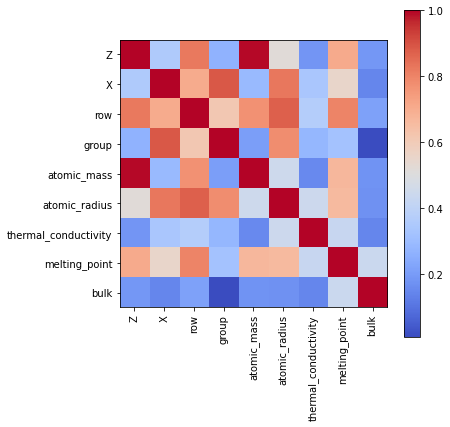

In [90]:
test_df = X.copy()
test_df[pred_val] = y
test_df

corr_matrix = test_df.corr()

plt.figure(figsize=(6,6))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()  # add color intensity map

plt.xticks(rotation=90)

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.show()

Диаграмма корреляций прогнозируемой величины с величинами из набора векторов признаков:

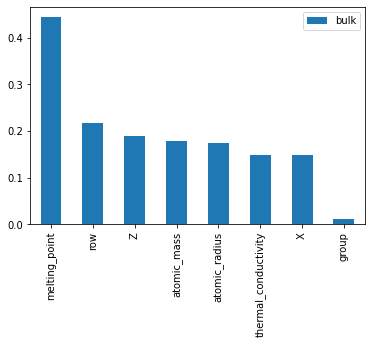

In [91]:
data_4_analysis = pd.DataFrame().append(X)
data_4_analysis[pred_val] = y

# bar plot
pd.DataFrame(data_4_analysis.corr()[pred_val]).\
             drop(index=[pred_val]).\
             sort_values(by=[pred_val], ascending=False).\
             plot(kind='bar')
plt.show()

---

# Regression models

Regression metric:

In [92]:
scoring='neg_mean_absolute_error'

*Other regression metrics from sklearn:*
- `explained_variance`
- `max_error`
- `neg_mean_absolute_error`
- `neg_mean_squared_error`
- `neg_root_mean_squared_error`
- `neg_mean_squared_log_error`
- `neg_median_absolute_error`
- `r2`
- `neg_mean_poisson_deviance`
- `neg_mean_gamma_deviance`
- `neg_mean_absolute_percentage_error`

In [93]:
res_table = pd.DataFrame()
tmp={}

## Linear regression

Cooresponding libraries

In [94]:
from sklearn.linear_model import LinearRegression

Функция построения графика $y_{pred}=f(y_{true})$ и отображения метрики $R^2$ в кросс-валидации:

In [95]:
def ex_plot(model_name, y_true, y_pred, scores):
    fig, ax = plt.subplots(figsize=(6,6))
    
    plt.plot(y_test, y_pred, 'o', label=str(scoring)+'(C-V) = '+str(round(scores,2)))
    
    max_dimension = max(y_test.max(), y_pred.max())
    min_dimension = min(y_test.min(), y_pred.min())
    
    x_line = [min_dimension, max_dimension]
    y_line = x_line
    
    plt.plot(x_line, y_line)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.legend()
    plt.title(model_name)
    
    plt.show()

---

Применение модели линейной регрессии:

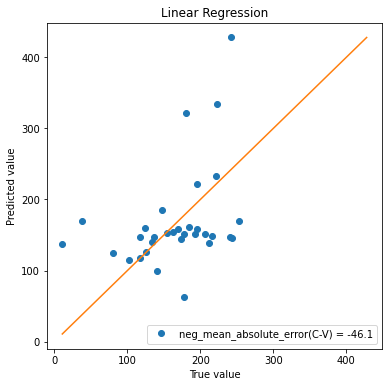

In [96]:
lr = LinearRegression()

''' MODEL FIT '''
lr.fit(X_train, y_train)
   
''' Cross-Validation '''
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=scoring)

''' PLOT '''
ex_plot('Linear Regression', y_test, lr.predict(X_test), scores.mean())

tmp['model'] = 'lr'
tmp[scoring] = scores.mean()
res_table = res_table.append([tmp])

---

## kNN

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.6s finished


{'n_neighbors': 2}


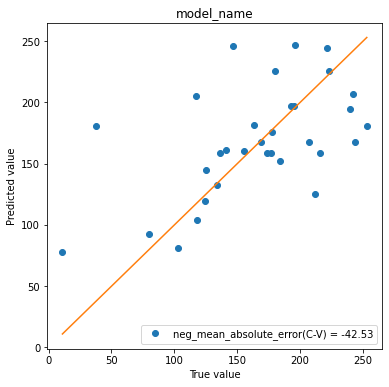

In [97]:
# Загрузка библиотек
from sklearn.neighbors import KNeighborsRegressor

# Инициализация модели МО:
model_knr = KNeighborsRegressor()

# Массив числа соседей для перебора
n_neighbors = np.arange(1,15,1) # from 1 to 10

# Определение сетки параметров
param_grid = {'n_neighbors': n_neighbors}

# Инициирование поиска по сетке параметров
gs = GridSearchCV(model_knr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

# Определение наилучшей параметризации
model_best = gs.best_estimator_ 
print(gs.best_params_)
ex_plot('model_name', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [98]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
knn_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'knn'
tmp[scoring] = knn_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## SVM

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    2.3s finished


{'C': 1000, 'degree': 1, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.01}


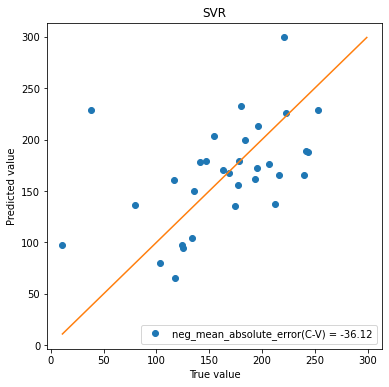

In [99]:
# Загрузка библиотек
from sklearn.svm import SVR

# Инициализация модели МО:
svr = SVR()

# Массив параметров для перебора
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [1,2,3,5]
tol = [0.001, 0.01]
C = [100, 1000]
epsilon = [0.2, 0.3, 0.5]

param_grid = {'kernel': kernel, 'degree' : degree, 'tol' : tol, 'C' : C, 'epsilon' : epsilon}

gs = GridSearchCV(svr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('SVR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').max())

In [100]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
svm_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'svm'
tmp[scoring] = svm_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## RFR

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   26.6s finished


{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 0.001, 'n_estimators': 500}


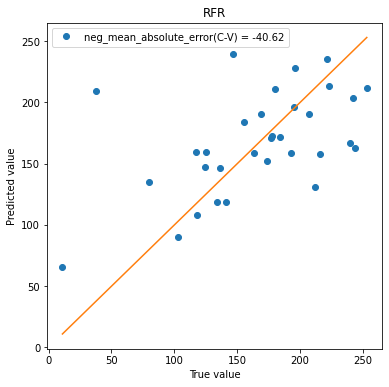

In [101]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()

n_estimators = [300,500]
max_features = ['auto']
max_depth = [1,40,100]
min_samples_split = [0.0001,0.001,0.01]
min_samples_leaf = [1,2]
bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(RFR, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('RFR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [102]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
rfr_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'rfr'
tmp[scoring] = rfr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## GBR

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   22.7s finished


------------------------------
Параметры наилучшего варианта:
{'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 350}


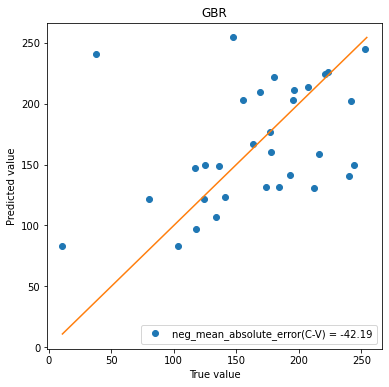

------------------------------


In [103]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

# Массивы значений параметров для поиска по сетке
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [300,350]
min_samples_split = [0.001,0.01, 0.1]
min_samples_leaf = [1,2]
max_depth = [1,5,15]

param_grid = { 'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth}

gs = GridSearchCV(gbr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print("------------------------------")
print("Параметры наилучшего варианта:")
print(gs.best_params_)
ex_plot('GBR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())
print("------------------------------")

In [104]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
gbr_res = results.sort_values(by='rank').set_index('rank').head(3)

tmp['model'] = 'gbr'
tmp[scoring] = gbr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

## Simple regressors summary

In [105]:
res_table

,model,neg_mean_absolute_error
0,lr,-46.097961
0,knn,-38.819692
0,svm,-36.116748
0,rfr,-34.784257
0,gbr,-32.707826


---

# Keras model

In [106]:
# pre-requirements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# keras-tuner (general)
import tensorflow.keras as keras

# hyperparameter optimization algorithm
from kerastuner import Hyperband # OTHER MODULES: RandomSearch, BayesianOptimization

# easy calling
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

In [107]:
inputdim = X.shape[1]

def build_model(hp):
    
    ''' trial parameters '''
    # model type selection
    model = Sequential()
        
    # model hyperparameters
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid'])
    optimizer_choice = hp.Choice('optimizer', values=['adam','rmsprop','SGD'])
    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 
    
    ''' ANN STRUCTURE '''
    # first h-layer
    model.add(Dense(units=hp.Int('layer_1', min_value=20, max_value=200, step=20),
                    input_dim=inputdim,
                    activation=activation_choice))
    
    # other h-layer 
    # optimized for perfomance
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(units=hp.Int('layer_' + str(i), min_value=20, max_value=100, step=20),
                        activation=activation_choice))
    
    # output layer
    model.add(Dense(1))
    
    ''' instantiate ANN '''
    model.compile(optimizer=optimizer_choice,
                  loss='MAE',
                  metrics=['MAE'])
    return model

In [111]:
tuner = Hyperband(build_model,
                  objective='val_MAE',
                  max_epochs=500, # for Hyperband only
                  #max_trials=20, # for BayesianOptimization & RandomSearch
                  directory='test_dir') #, # ATTENTION! path should be latin!!!!!!
                  #overwrite=True) # overwrite all previous models in specified directory

INFO:tensorflow:Reloading Oracle from existing project test_dir\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from test_dir\untitled_project\tuner0.json


In [112]:
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, 
             batch_size=200, # optimal batch size preselected
             # epochs=500,   # for BayesianOptimization & RandomSearch
             validation_split=0.2,
             verbose=2)

Epoch 1/3
1/1 - 0s - loss: 154.1013 - MAE: 154.1013 - val_loss: 143.0750 - val_MAE: 143.0750
Epoch 2/3
1/1 - 0s - loss: 154.0095 - MAE: 154.0095 - val_loss: 142.9832 - val_MAE: 142.9832
Epoch 3/3
1/1 - 0s - loss: 153.9177 - MAE: 153.9177 - val_loss: 142.8913 - val_MAE: 142.8913


Epoch 1/3
1/1 - 0s - loss: 154.0837 - MAE: 154.0837 - val_loss: 143.1259 - val_MAE: 143.1259
Epoch 2/3
1/1 - 0s - loss: 154.0587 - MAE: 154.0587 - val_loss: 143.1003 - val_MAE: 143.1003
Epoch 3/3
1/1 - 0s - loss: 154.0330 - MAE: 154.0330 - val_loss: 143.0741 - val_MAE: 143.0741


Epoch 1/3
1/1 - 0s - loss: 154.2884 - MAE: 154.2884 - val_loss: 143.1795 - val_MAE: 143.1795
Epoch 2/3
1/1 - 0s - loss: 154.1138 - MAE: 154.1138 - val_loss: 143.0050 - val_MAE: 143.0050
Epoch 3/3
1/1 - 0s - loss: 153.9393 - MAE: 153.9393 - val_loss: 142.8305 - val_MAE: 142.8305


Epoch 1/3
1/1 - 0s - loss: 153.8625 - MAE: 153.8625 - val_loss: 142.8026 - val_MAE: 142.8026
Epoch 2/3
1/1 - 0s - loss: 153.7370 - MAE: 153.7370 - val_loss: 142.6769 - val_MAE: 142.6769
Epoch 3/3
1/1 - 0s - loss: 153.6113 - MAE: 153.6113 - val_loss: 142.5510 - val_MAE: 142.5510


Epoch 1/3
1/1 - 0s - loss: 154.0786 - MAE: 154.0786 - val_loss: 143.1167 - val_MAE: 143.1167
Epoch 2/3
1/1 - 0s - loss: 154.0531 - MAE: 154.0531 - val_loss: 143.0898 - val_MAE: 143.0898
Epoch 3/3
1/1 - 0s - loss: 154.0271 - MAE: 154.0271 - val_loss: 143.0597 - val_MAE: 143.0597


Epoch 1/3
1/1 - 0s - loss: 154.1044 - MAE: 154.1044 - val_loss: 143.1468 - val_MAE: 143.1468
Epoch 2/3
1/1 - 0s - loss: 154.0793 - MAE: 154.0793 - val_loss: 143.1232 - val_MAE: 143.1232
Epoch 3/3
1/1 - 0s - loss: 154.0561 - MAE: 154.0561 - val_loss: 143.1006 - val_MAE: 143.1006


Epoch 1/3
1/1 - 0s - loss: 154.1123 - MAE: 154.1123 - val_loss: 143.1078 - val_MAE: 143.1078
Epoch 2/3
1/1 - 0s - loss: 154.0426 - MAE: 154.0426 - val_loss: 143.0412 - val_MAE: 143.0412
Epoch 3/3
1/1 - 0s - loss: 153.9811 - MAE: 153.9811 - val_loss: 142.9704 - val_MAE: 142.9704


Epoch 1/3
1/1 - 0s - loss: 154.0736 - MAE: 154.0736 - val_loss: 143.1190 - val_MAE: 143.1190
Epoch 2/3
1/1 - 0s - loss: 154.0541 - MAE: 154.0541 - val_loss: 143.0987 - val_MAE: 143.0987
Epoch 3/3
1/1 - 0s - loss: 154.0339 - MAE: 154.0339 - val_loss: 143.0774 - val_MAE: 143.0774


Epoch 1/3
1/1 - 0s - loss: 154.0867 - MAE: 154.0867 - val_loss: 143.1284 - val_MAE: 143.1284
Epoch 2/3
1/1 - 0s - loss: 154.0636 - MAE: 154.0636 - val_loss: 143.1068 - val_MAE: 143.1068
Epoch 3/3
1/1 - 0s - loss: 154.0423 - MAE: 154.0423 - val_loss: 143.0856 - val_MAE: 143.0856


Epoch 1/3
1/1 - 0s - loss: 154.0881 - MAE: 154.0881 - val_loss: 143.1402 - val_MAE: 143.1402
Epoch 2/3
1/1 - 0s - loss: 154.0760 - MAE: 154.0760 - val_loss: 143.1261 - val_MAE: 143.1261
Epoch 3/3
1/1 - 0s - loss: 154.0624 - MAE: 154.0624 - val_loss: 143.1113 - val_MAE: 143.1113


Epoch 1/3
1/1 - 0s - loss: 154.0750 - MAE: 154.0750 - val_loss: 143.1194 - val_MAE: 143.1194
Epoch 2/3
1/1 - 0s - loss: 154.0562 - MAE: 154.0562 - val_loss: 143.1006 - val_MAE: 143.1006
Epoch 3/3
1/1 - 0s - loss: 154.0388 - MAE: 154.0388 - val_loss: 143.0813 - val_MAE: 143.0813


Epoch 1/3
1/1 - 0s - loss: 154.1001 - MAE: 154.1001 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0390 - MAE: 154.0390 - val_loss: 143.0228 - val_MAE: 143.0228
Epoch 3/3
1/1 - 0s - loss: 153.9662 - MAE: 153.9662 - val_loss: 142.9150 - val_MAE: 142.9150


Epoch 1/3
1/1 - 0s - loss: 153.4438 - MAE: 153.4438 - val_loss: 142.2142 - val_MAE: 142.2142
Epoch 2/3
1/1 - 0s - loss: 153.1486 - MAE: 153.1486 - val_loss: 141.9205 - val_MAE: 141.9205
Epoch 3/3
1/1 - 0s - loss: 152.8549 - MAE: 152.8549 - val_loss: 141.6295 - val_MAE: 141.6295


Epoch 1/3
1/1 - 0s - loss: 154.0900 - MAE: 154.0900 - val_loss: 143.1292 - val_MAE: 143.1292
Epoch 2/3
1/1 - 0s - loss: 154.0655 - MAE: 154.0655 - val_loss: 143.1063 - val_MAE: 143.1063
Epoch 3/3
1/1 - 0s - loss: 154.0430 - MAE: 154.0430 - val_loss: 143.0836 - val_MAE: 143.0836


Epoch 1/3
1/1 - 0s - loss: 154.0719 - MAE: 154.0719 - val_loss: 143.0462 - val_MAE: 143.0462
Epoch 2/3
1/1 - 0s - loss: 153.9873 - MAE: 153.9873 - val_loss: 142.9386 - val_MAE: 142.9386
Epoch 3/3
1/1 - 0s - loss: 153.8873 - MAE: 153.8873 - val_loss: 142.8130 - val_MAE: 142.8130


Epoch 1/3
1/1 - 0s - loss: 154.8526 - MAE: 154.8526 - val_loss: 143.8306 - val_MAE: 143.8306
Epoch 2/3
1/1 - 0s - loss: 154.7650 - MAE: 154.7650 - val_loss: 143.7432 - val_MAE: 143.7432
Epoch 3/3
1/1 - 0s - loss: 154.6776 - MAE: 154.6776 - val_loss: 143.6561 - val_MAE: 143.6561


Epoch 1/3
1/1 - 0s - loss: 154.0875 - MAE: 154.0875 - val_loss: 143.1377 - val_MAE: 143.1377
Epoch 2/3
1/1 - 0s - loss: 154.0732 - MAE: 154.0732 - val_loss: 143.1227 - val_MAE: 143.1227
Epoch 3/3
1/1 - 0s - loss: 154.0590 - MAE: 154.0590 - val_loss: 143.1072 - val_MAE: 143.1072


Epoch 1/3
1/1 - 0s - loss: 154.0319 - MAE: 154.0319 - val_loss: 143.0672 - val_MAE: 143.0672
Epoch 2/3
1/1 - 0s - loss: 154.0028 - MAE: 154.0028 - val_loss: 143.0366 - val_MAE: 143.0366
Epoch 3/3
1/1 - 0s - loss: 153.9727 - MAE: 153.9727 - val_loss: 143.0058 - val_MAE: 143.0058


Epoch 1/3
1/1 - 0s - loss: 153.3554 - MAE: 153.3554 - val_loss: 142.1121 - val_MAE: 142.1121
Epoch 2/3
1/1 - 0s - loss: 153.0466 - MAE: 153.0466 - val_loss: 141.8034 - val_MAE: 141.8034
Epoch 3/3
1/1 - 0s - loss: 152.7379 - MAE: 152.7379 - val_loss: 141.4949 - val_MAE: 141.4949


Epoch 1/3
1/1 - 0s - loss: 154.0883 - MAE: 154.0883 - val_loss: 143.1156 - val_MAE: 143.1156
Epoch 2/3
1/1 - 0s - loss: 154.0527 - MAE: 154.0527 - val_loss: 143.0819 - val_MAE: 143.0819
Epoch 3/3
1/1 - 0s - loss: 154.0211 - MAE: 154.0211 - val_loss: 143.0442 - val_MAE: 143.0442


Epoch 1/3
1/1 - 0s - loss: 153.5785 - MAE: 153.5785 - val_loss: 142.2684 - val_MAE: 142.2684
Epoch 2/3
1/1 - 0s - loss: 153.2028 - MAE: 153.2028 - val_loss: 141.9923 - val_MAE: 141.9923
Epoch 3/3
1/1 - 0s - loss: 152.9267 - MAE: 152.9267 - val_loss: 141.7574 - val_MAE: 141.7574


Epoch 1/3
1/1 - 0s - loss: 153.3372 - MAE: 153.3372 - val_loss: 142.2694 - val_MAE: 142.2694
Epoch 2/3
1/1 - 0s - loss: 153.2034 - MAE: 153.2034 - val_loss: 142.1354 - val_MAE: 142.1354
Epoch 3/3
1/1 - 0s - loss: 153.0694 - MAE: 153.0694 - val_loss: 142.0011 - val_MAE: 142.0011


Epoch 1/3
1/1 - 0s - loss: 153.0632 - MAE: 153.0632 - val_loss: 141.9837 - val_MAE: 141.9837
Epoch 2/3
1/1 - 0s - loss: 152.9181 - MAE: 152.9181 - val_loss: 141.8387 - val_MAE: 141.8387
Epoch 3/3
1/1 - 0s - loss: 152.7731 - MAE: 152.7731 - val_loss: 141.6941 - val_MAE: 141.6941


Epoch 1/3
1/1 - 0s - loss: 154.0460 - MAE: 154.0460 - val_loss: 143.0703 - val_MAE: 143.0703
Epoch 2/3
1/1 - 0s - loss: 154.0114 - MAE: 154.0114 - val_loss: 143.0335 - val_MAE: 143.0335
Epoch 3/3
1/1 - 0s - loss: 153.9764 - MAE: 153.9764 - val_loss: 142.9942 - val_MAE: 142.9942


Epoch 1/3
1/1 - 0s - loss: 156.4001 - MAE: 156.4001 - val_loss: 144.8217 - val_MAE: 144.8217
Epoch 2/3
1/1 - 0s - loss: 155.7561 - MAE: 155.7561 - val_loss: 144.3637 - val_MAE: 144.3637
Epoch 3/3
1/1 - 0s - loss: 155.2982 - MAE: 155.2982 - val_loss: 143.9851 - val_MAE: 143.9851


Epoch 1/3
1/1 - 0s - loss: 154.0837 - MAE: 154.0837 - val_loss: 143.1036 - val_MAE: 143.1036
Epoch 2/3
1/1 - 0s - loss: 154.0376 - MAE: 154.0376 - val_loss: 143.0441 - val_MAE: 143.0441
Epoch 3/3
1/1 - 0s - loss: 153.9785 - MAE: 153.9785 - val_loss: 142.9735 - val_MAE: 142.9735


Epoch 1/3
1/1 - 0s - loss: 154.2175 - MAE: 154.2175 - val_loss: 142.9661 - val_MAE: 142.9661
Epoch 2/3
1/1 - 0s - loss: 153.9005 - MAE: 153.9005 - val_loss: 142.6489 - val_MAE: 142.6489
Epoch 3/3
1/1 - 0s - loss: 153.5834 - MAE: 153.5834 - val_loss: 142.3316 - val_MAE: 142.3316


Epoch 1/3
1/1 - 0s - loss: 154.0493 - MAE: 154.0493 - val_loss: 143.0627 - val_MAE: 143.0627
Epoch 2/3
1/1 - 0s - loss: 154.0043 - MAE: 154.0043 - val_loss: 143.0122 - val_MAE: 143.0122
Epoch 3/3
1/1 - 0s - loss: 153.9571 - MAE: 153.9571 - val_loss: 142.9562 - val_MAE: 142.9562


Epoch 1/3
1/1 - 0s - loss: 154.0938 - MAE: 154.0938 - val_loss: 143.1213 - val_MAE: 143.1213
Epoch 2/3
1/1 - 0s - loss: 154.0602 - MAE: 154.0602 - val_loss: 143.0889 - val_MAE: 143.0889
Epoch 3/3
1/1 - 0s - loss: 154.0304 - MAE: 154.0304 - val_loss: 143.0578 - val_MAE: 143.0578


Epoch 1/3
1/1 - 0s - loss: 155.1358 - MAE: 155.1358 - val_loss: 144.0090 - val_MAE: 144.0090
Epoch 2/3
1/1 - 0s - loss: 154.9434 - MAE: 154.9434 - val_loss: 143.8175 - val_MAE: 143.8175
Epoch 3/3
1/1 - 0s - loss: 154.7518 - MAE: 154.7518 - val_loss: 143.6267 - val_MAE: 143.6267


Epoch 1/3
1/1 - 0s - loss: 153.0589 - MAE: 153.0589 - val_loss: 141.9993 - val_MAE: 141.9993
Epoch 2/3
1/1 - 0s - loss: 152.9337 - MAE: 152.9337 - val_loss: 141.8740 - val_MAE: 141.8740
Epoch 3/3
1/1 - 0s - loss: 152.8084 - MAE: 152.8084 - val_loss: 141.7485 - val_MAE: 141.7485


Epoch 1/3
1/1 - 0s - loss: 154.0693 - MAE: 154.0693 - val_loss: 143.0047 - val_MAE: 143.0047
Epoch 2/3
1/1 - 0s - loss: 153.9543 - MAE: 153.9543 - val_loss: 142.8766 - val_MAE: 142.8766
Epoch 3/3
1/1 - 0s - loss: 153.8371 - MAE: 153.8371 - val_loss: 142.7233 - val_MAE: 142.7233


Epoch 1/3
1/1 - 0s - loss: 154.0598 - MAE: 154.0598 - val_loss: 143.0108 - val_MAE: 143.0108
Epoch 2/3
1/1 - 0s - loss: 153.9545 - MAE: 153.9545 - val_loss: 142.8905 - val_MAE: 142.8905
Epoch 3/3
1/1 - 0s - loss: 153.8399 - MAE: 153.8399 - val_loss: 142.7472 - val_MAE: 142.7472


Epoch 1/3
1/1 - 0s - loss: 154.0577 - MAE: 154.0577 - val_loss: 143.0212 - val_MAE: 143.0212
Epoch 2/3
1/1 - 0s - loss: 153.9625 - MAE: 153.9625 - val_loss: 142.9074 - val_MAE: 142.9074
Epoch 3/3
1/1 - 0s - loss: 153.8541 - MAE: 153.8541 - val_loss: 142.7727 - val_MAE: 142.7727


Epoch 1/3
1/1 - 0s - loss: 154.1036 - MAE: 154.1036 - val_loss: 143.1302 - val_MAE: 143.1302
Epoch 2/3
1/1 - 0s - loss: 154.0651 - MAE: 154.0651 - val_loss: 143.0875 - val_MAE: 143.0875
Epoch 3/3
1/1 - 0s - loss: 154.0253 - MAE: 154.0253 - val_loss: 143.0269 - val_MAE: 143.0269


Epoch 1/3
1/1 - 0s - loss: 154.1068 - MAE: 154.1068 - val_loss: 143.1512 - val_MAE: 143.1512
Epoch 2/3
1/1 - 0s - loss: 154.0845 - MAE: 154.0845 - val_loss: 143.1294 - val_MAE: 143.1294
Epoch 3/3
1/1 - 0s - loss: 154.0633 - MAE: 154.0633 - val_loss: 143.1086 - val_MAE: 143.1086


Epoch 1/3
1/1 - 0s - loss: 154.0860 - MAE: 154.0860 - val_loss: 143.1230 - val_MAE: 143.1230
Epoch 2/3
1/1 - 0s - loss: 154.0576 - MAE: 154.0576 - val_loss: 143.0970 - val_MAE: 143.0970
Epoch 3/3
1/1 - 0s - loss: 154.0313 - MAE: 154.0313 - val_loss: 143.0699 - val_MAE: 143.0699


Epoch 1/3
1/1 - 0s - loss: 154.0730 - MAE: 154.0730 - val_loss: 143.1046 - val_MAE: 143.1046
Epoch 2/3
1/1 - 0s - loss: 154.0431 - MAE: 154.0431 - val_loss: 143.0717 - val_MAE: 143.0717
Epoch 3/3
1/1 - 0s - loss: 154.0125 - MAE: 154.0125 - val_loss: 143.0373 - val_MAE: 143.0373


Epoch 1/3
1/1 - 0s - loss: 154.9338 - MAE: 154.9338 - val_loss: 142.9204 - val_MAE: 142.9204
Epoch 2/3
1/1 - 0s - loss: 153.8548 - MAE: 153.8548 - val_loss: 142.1605 - val_MAE: 142.1605
Epoch 3/3
1/1 - 0s - loss: 153.0950 - MAE: 153.0950 - val_loss: 141.5482 - val_MAE: 141.5482


Epoch 1/3
1/1 - 0s - loss: 154.4582 - MAE: 154.4582 - val_loss: 143.3004 - val_MAE: 143.3004
Epoch 2/3
1/1 - 0s - loss: 154.2348 - MAE: 154.2348 - val_loss: 143.0772 - val_MAE: 143.0772
Epoch 3/3
1/1 - 0s - loss: 154.0116 - MAE: 154.0116 - val_loss: 142.8540 - val_MAE: 142.8540


Epoch 1/3
1/1 - 0s - loss: 154.0834 - MAE: 154.0834 - val_loss: 143.1270 - val_MAE: 143.1270
Epoch 2/3
1/1 - 0s - loss: 154.0631 - MAE: 154.0631 - val_loss: 143.1047 - val_MAE: 143.1047
Epoch 3/3
1/1 - 0s - loss: 154.0415 - MAE: 154.0415 - val_loss: 143.0796 - val_MAE: 143.0796


Epoch 1/3
1/1 - 0s - loss: 155.0346 - MAE: 155.0346 - val_loss: 143.7384 - val_MAE: 143.7384
Epoch 2/3
1/1 - 0s - loss: 154.6728 - MAE: 154.6728 - val_loss: 143.3793 - val_MAE: 143.3793
Epoch 3/3
1/1 - 0s - loss: 154.3138 - MAE: 154.3138 - val_loss: 143.0242 - val_MAE: 143.0242


Epoch 1/3
1/1 - 0s - loss: 154.7515 - MAE: 154.7515 - val_loss: 143.7534 - val_MAE: 143.7534
Epoch 2/3
1/1 - 0s - loss: 154.6878 - MAE: 154.6878 - val_loss: 143.6899 - val_MAE: 143.6899
Epoch 3/3
1/1 - 0s - loss: 154.6243 - MAE: 154.6243 - val_loss: 143.6267 - val_MAE: 143.6267


Epoch 1/3
1/1 - 0s - loss: 154.1198 - MAE: 154.1198 - val_loss: 143.1537 - val_MAE: 143.1537
Epoch 2/3
1/1 - 0s - loss: 154.0918 - MAE: 154.0918 - val_loss: 143.1256 - val_MAE: 143.1256
Epoch 3/3
1/1 - 0s - loss: 154.0665 - MAE: 154.0665 - val_loss: 143.1004 - val_MAE: 143.1004


Epoch 1/3
1/1 - 0s - loss: 153.8418 - MAE: 153.8418 - val_loss: 142.5368 - val_MAE: 142.5368
Epoch 2/3
1/1 - 0s - loss: 153.4712 - MAE: 153.4712 - val_loss: 142.2730 - val_MAE: 142.2730
Epoch 3/3
1/1 - 0s - loss: 153.2074 - MAE: 153.2074 - val_loss: 142.0540 - val_MAE: 142.0540


Epoch 1/3
1/1 - 0s - loss: 154.1205 - MAE: 154.1205 - val_loss: 143.1564 - val_MAE: 143.1564
Epoch 2/3
1/1 - 0s - loss: 154.0905 - MAE: 154.0905 - val_loss: 143.1331 - val_MAE: 143.1331
Epoch 3/3
1/1 - 0s - loss: 154.0686 - MAE: 154.0686 - val_loss: 143.1140 - val_MAE: 143.1140


Epoch 1/3
1/1 - 0s - loss: 154.8909 - MAE: 154.8909 - val_loss: 143.2832 - val_MAE: 143.2832
Epoch 2/3
1/1 - 0s - loss: 154.2177 - MAE: 154.2177 - val_loss: 142.7955 - val_MAE: 142.7955
Epoch 3/3
1/1 - 0s - loss: 153.7299 - MAE: 153.7299 - val_loss: 142.3763 - val_MAE: 142.3763


Epoch 1/3
1/1 - 0s - loss: 154.0903 - MAE: 154.0903 - val_loss: 143.1155 - val_MAE: 143.1155
Epoch 2/3
1/1 - 0s - loss: 154.0496 - MAE: 154.0496 - val_loss: 143.0734 - val_MAE: 143.0734
Epoch 3/3
1/1 - 0s - loss: 154.0100 - MAE: 154.0100 - val_loss: 143.0299 - val_MAE: 143.0299


Epoch 1/3
1/1 - 0s - loss: 153.8133 - MAE: 153.8133 - val_loss: 142.6568 - val_MAE: 142.6568
Epoch 2/3
1/1 - 0s - loss: 153.5911 - MAE: 153.5911 - val_loss: 142.4344 - val_MAE: 142.4344
Epoch 3/3
1/1 - 0s - loss: 153.3688 - MAE: 153.3688 - val_loss: 142.2117 - val_MAE: 142.2117


Epoch 1/3
1/1 - 0s - loss: 154.0880 - MAE: 154.0880 - val_loss: 143.1304 - val_MAE: 143.1304
Epoch 2/3
1/1 - 0s - loss: 154.0670 - MAE: 154.0670 - val_loss: 143.1114 - val_MAE: 143.1114
Epoch 3/3
1/1 - 0s - loss: 154.0494 - MAE: 154.0494 - val_loss: 143.0905 - val_MAE: 143.0905


Epoch 1/3
1/1 - 0s - loss: 154.0898 - MAE: 154.0898 - val_loss: 142.8708 - val_MAE: 142.8708
Epoch 2/3
1/1 - 0s - loss: 153.8052 - MAE: 153.8052 - val_loss: 142.6612 - val_MAE: 142.6612
Epoch 3/3
1/1 - 0s - loss: 153.5955 - MAE: 153.5955 - val_loss: 142.4830 - val_MAE: 142.4830


Epoch 1/3
1/1 - 0s - loss: 154.7388 - MAE: 154.7388 - val_loss: 143.6922 - val_MAE: 143.6922
Epoch 2/3
1/1 - 0s - loss: 154.6265 - MAE: 154.6265 - val_loss: 143.5797 - val_MAE: 143.5797
Epoch 3/3
1/1 - 0s - loss: 154.5141 - MAE: 154.5141 - val_loss: 143.4671 - val_MAE: 143.4671


Epoch 1/3
1/1 - 0s - loss: 154.0959 - MAE: 154.0959 - val_loss: 143.1422 - val_MAE: 143.1422
Epoch 2/3
1/1 - 0s - loss: 154.0750 - MAE: 154.0750 - val_loss: 143.1224 - val_MAE: 143.1224
Epoch 3/3
1/1 - 0s - loss: 154.0552 - MAE: 154.0552 - val_loss: 143.1026 - val_MAE: 143.1026


Epoch 1/3
1/1 - 0s - loss: 152.6662 - MAE: 152.6662 - val_loss: 141.5060 - val_MAE: 141.5060
Epoch 2/3
1/1 - 0s - loss: 152.4404 - MAE: 152.4404 - val_loss: 141.2793 - val_MAE: 141.2793
Epoch 3/3
1/1 - 0s - loss: 152.2137 - MAE: 152.2137 - val_loss: 141.0595 - val_MAE: 141.0595


Epoch 1/3
1/1 - 0s - loss: 154.0682 - MAE: 154.0682 - val_loss: 143.0642 - val_MAE: 143.0642
Epoch 2/3
1/1 - 0s - loss: 154.0030 - MAE: 154.0030 - val_loss: 142.9809 - val_MAE: 142.9809
Epoch 3/3
1/1 - 0s - loss: 153.9235 - MAE: 153.9235 - val_loss: 142.8705 - val_MAE: 142.8705


Epoch 1/3
1/1 - 0s - loss: 154.0814 - MAE: 154.0814 - val_loss: 143.1260 - val_MAE: 143.1260
Epoch 2/3
1/1 - 0s - loss: 154.0626 - MAE: 154.0626 - val_loss: 143.1096 - val_MAE: 143.1096
Epoch 3/3
1/1 - 0s - loss: 154.0462 - MAE: 154.0462 - val_loss: 143.0930 - val_MAE: 143.0930


Epoch 1/3
1/1 - 0s - loss: 153.0996 - MAE: 153.0996 - val_loss: 141.7501 - val_MAE: 141.7501
Epoch 2/3
1/1 - 0s - loss: 152.6844 - MAE: 152.6844 - val_loss: 141.4453 - val_MAE: 141.4453
Epoch 3/3
1/1 - 0s - loss: 152.3796 - MAE: 152.3796 - val_loss: 141.1903 - val_MAE: 141.1903


Epoch 1/3
1/1 - 0s - loss: 152.6886 - MAE: 152.6886 - val_loss: 141.5614 - val_MAE: 141.5614
Epoch 2/3
1/1 - 0s - loss: 152.4957 - MAE: 152.4957 - val_loss: 141.3678 - val_MAE: 141.3678
Epoch 3/3
1/1 - 0s - loss: 152.3021 - MAE: 152.3021 - val_loss: 141.1735 - val_MAE: 141.1735


Epoch 1/3
1/1 - 0s - loss: 154.7040 - MAE: 154.7040 - val_loss: 143.6519 - val_MAE: 143.6519
Epoch 2/3
1/1 - 0s - loss: 154.5863 - MAE: 154.5863 - val_loss: 143.5345 - val_MAE: 143.5345
Epoch 3/3
1/1 - 0s - loss: 154.4689 - MAE: 154.4689 - val_loss: 143.4174 - val_MAE: 143.4174


Epoch 1/3
1/1 - 0s - loss: 153.9570 - MAE: 153.9570 - val_loss: 142.9587 - val_MAE: 142.9587
Epoch 2/3
1/1 - 0s - loss: 153.8931 - MAE: 153.8931 - val_loss: 142.8950 - val_MAE: 142.8950
Epoch 3/3
1/1 - 0s - loss: 153.8293 - MAE: 153.8293 - val_loss: 142.8313 - val_MAE: 142.8313


Epoch 1/3
1/1 - 0s - loss: 153.1115 - MAE: 153.1115 - val_loss: 141.9582 - val_MAE: 141.9582
Epoch 2/3
1/1 - 0s - loss: 152.8926 - MAE: 152.8926 - val_loss: 141.7402 - val_MAE: 141.7402
Epoch 3/3
1/1 - 0s - loss: 152.6746 - MAE: 152.6746 - val_loss: 141.5235 - val_MAE: 141.5235


Epoch 1/3
1/1 - 0s - loss: 153.8376 - MAE: 153.8376 - val_loss: 142.4437 - val_MAE: 142.4437
Epoch 2/3
1/1 - 0s - loss: 153.3781 - MAE: 153.3781 - val_loss: 142.1126 - val_MAE: 142.1126
Epoch 3/3
1/1 - 0s - loss: 153.0470 - MAE: 153.0470 - val_loss: 141.8276 - val_MAE: 141.8276


Epoch 1/3
1/1 - 0s - loss: 154.2391 - MAE: 154.2391 - val_loss: 143.0232 - val_MAE: 143.0232
Epoch 2/3
1/1 - 0s - loss: 153.9576 - MAE: 153.9576 - val_loss: 142.7418 - val_MAE: 142.7418
Epoch 3/3
1/1 - 0s - loss: 153.6762 - MAE: 153.6762 - val_loss: 142.4602 - val_MAE: 142.4602


Epoch 1/3
1/1 - 0s - loss: 154.0756 - MAE: 154.0756 - val_loss: 143.1177 - val_MAE: 143.1177
Epoch 2/3
1/1 - 0s - loss: 154.0541 - MAE: 154.0541 - val_loss: 143.0963 - val_MAE: 143.0963
Epoch 3/3
1/1 - 0s - loss: 154.0331 - MAE: 154.0331 - val_loss: 143.0744 - val_MAE: 143.0744


Epoch 1/3
1/1 - 0s - loss: 155.0200 - MAE: 155.0200 - val_loss: 143.8564 - val_MAE: 143.8564
Epoch 2/3
1/1 - 0s - loss: 154.7908 - MAE: 154.7908 - val_loss: 143.6907 - val_MAE: 143.6907
Epoch 3/3
1/1 - 0s - loss: 154.6251 - MAE: 154.6251 - val_loss: 143.5518 - val_MAE: 143.5518


Epoch 1/3
1/1 - 0s - loss: 154.5060 - MAE: 154.5060 - val_loss: 143.4038 - val_MAE: 143.4038
Epoch 2/3
1/1 - 0s - loss: 154.3383 - MAE: 154.3383 - val_loss: 143.2372 - val_MAE: 143.2372
Epoch 3/3
1/1 - 0s - loss: 154.1716 - MAE: 154.1716 - val_loss: 143.0716 - val_MAE: 143.0716


Epoch 1/3
1/1 - 0s - loss: 154.1058 - MAE: 154.1058 - val_loss: 143.1494 - val_MAE: 143.1494
Epoch 2/3
1/1 - 0s - loss: 154.0823 - MAE: 154.0823 - val_loss: 143.1279 - val_MAE: 143.1279
Epoch 3/3
1/1 - 0s - loss: 154.0612 - MAE: 154.0612 - val_loss: 143.1077 - val_MAE: 143.1077


Epoch 1/3
1/1 - 0s - loss: 154.0571 - MAE: 154.0571 - val_loss: 143.0955 - val_MAE: 143.0955
Epoch 2/3
1/1 - 0s - loss: 154.0342 - MAE: 154.0342 - val_loss: 143.0730 - val_MAE: 143.0730
Epoch 3/3
1/1 - 0s - loss: 154.0119 - MAE: 154.0119 - val_loss: 143.0506 - val_MAE: 143.0506


Epoch 1/3
1/1 - 0s - loss: 153.5017 - MAE: 153.5017 - val_loss: 142.4410 - val_MAE: 142.4410
Epoch 2/3
1/1 - 0s - loss: 153.3754 - MAE: 153.3754 - val_loss: 142.3145 - val_MAE: 142.3145
Epoch 3/3
1/1 - 0s - loss: 153.2489 - MAE: 153.2489 - val_loss: 142.1877 - val_MAE: 142.1877


Epoch 1/3
1/1 - 0s - loss: 155.4819 - MAE: 155.4819 - val_loss: 144.3713 - val_MAE: 144.3713
Epoch 2/3
1/1 - 0s - loss: 155.3057 - MAE: 155.3057 - val_loss: 144.2439 - val_MAE: 144.2439
Epoch 3/3
1/1 - 0s - loss: 155.1783 - MAE: 155.1783 - val_loss: 144.1378 - val_MAE: 144.1378


Epoch 1/3
1/1 - 0s - loss: 153.3859 - MAE: 153.3859 - val_loss: 142.2630 - val_MAE: 142.2630
Epoch 2/3
1/1 - 0s - loss: 153.1974 - MAE: 153.1974 - val_loss: 142.0749 - val_MAE: 142.0749
Epoch 3/3
1/1 - 0s - loss: 153.0092 - MAE: 153.0092 - val_loss: 141.8876 - val_MAE: 141.8876


Epoch 1/3
1/1 - 0s - loss: 153.5514 - MAE: 153.5514 - val_loss: 142.2811 - val_MAE: 142.2811
Epoch 2/3
1/1 - 0s - loss: 153.2154 - MAE: 153.2154 - val_loss: 141.9449 - val_MAE: 141.9449
Epoch 3/3
1/1 - 0s - loss: 152.8791 - MAE: 152.8791 - val_loss: 141.6083 - val_MAE: 141.6083


Epoch 1/3
1/1 - 0s - loss: 154.0873 - MAE: 154.0873 - val_loss: 143.1358 - val_MAE: 143.1358
Epoch 2/3
1/1 - 0s - loss: 154.0677 - MAE: 154.0677 - val_loss: 143.1153 - val_MAE: 143.1153
Epoch 3/3
1/1 - 0s - loss: 154.0482 - MAE: 154.0482 - val_loss: 143.0946 - val_MAE: 143.0946


Epoch 1/3
1/1 - 0s - loss: 154.0913 - MAE: 154.0913 - val_loss: 143.1474 - val_MAE: 143.1474
Epoch 2/3
1/1 - 0s - loss: 154.0814 - MAE: 154.0814 - val_loss: 143.1370 - val_MAE: 143.1370
Epoch 3/3
1/1 - 0s - loss: 154.0707 - MAE: 154.0707 - val_loss: 143.1212 - val_MAE: 143.1212


Epoch 1/3
1/1 - 0s - loss: 154.0846 - MAE: 154.0846 - val_loss: 143.1186 - val_MAE: 143.1186
Epoch 2/3
1/1 - 0s - loss: 154.0535 - MAE: 154.0535 - val_loss: 143.0835 - val_MAE: 143.0835
Epoch 3/3
1/1 - 0s - loss: 154.0194 - MAE: 154.0194 - val_loss: 143.0443 - val_MAE: 143.0443


Epoch 1/3
1/1 - 0s - loss: 154.0567 - MAE: 154.0567 - val_loss: 142.9684 - val_MAE: 142.9684
Epoch 2/3
1/1 - 0s - loss: 153.9027 - MAE: 153.9027 - val_loss: 142.8146 - val_MAE: 142.8146
Epoch 3/3
1/1 - 0s - loss: 153.7489 - MAE: 153.7489 - val_loss: 142.6609 - val_MAE: 142.6609


Epoch 1/3
1/1 - 0s - loss: 154.2436 - MAE: 154.2436 - val_loss: 142.7963 - val_MAE: 142.7963
Epoch 2/3
1/1 - 0s - loss: 153.7310 - MAE: 153.7310 - val_loss: 142.4171 - val_MAE: 142.4171
Epoch 3/3
1/1 - 0s - loss: 153.3518 - MAE: 153.3518 - val_loss: 142.0900 - val_MAE: 142.0900


Epoch 1/3
1/1 - 0s - loss: 154.0925 - MAE: 154.0925 - val_loss: 143.1156 - val_MAE: 143.1156
Epoch 2/3
1/1 - 0s - loss: 154.0510 - MAE: 154.0510 - val_loss: 143.0587 - val_MAE: 143.0587
Epoch 3/3
1/1 - 0s - loss: 153.9963 - MAE: 153.9963 - val_loss: 142.9741 - val_MAE: 142.9741


Epoch 1/3
1/1 - 0s - loss: 154.0935 - MAE: 154.0935 - val_loss: 143.1344 - val_MAE: 143.1344
Epoch 2/3
1/1 - 0s - loss: 154.0704 - MAE: 154.0704 - val_loss: 143.1114 - val_MAE: 143.1114
Epoch 3/3
1/1 - 0s - loss: 154.0487 - MAE: 154.0487 - val_loss: 143.0884 - val_MAE: 143.0884


Epoch 1/3
1/1 - 0s - loss: 153.5861 - MAE: 153.5861 - val_loss: 142.6016 - val_MAE: 142.6016
Epoch 2/3
1/1 - 0s - loss: 153.5360 - MAE: 153.5360 - val_loss: 142.5520 - val_MAE: 142.5520
Epoch 3/3
1/1 - 0s - loss: 153.4865 - MAE: 153.4865 - val_loss: 142.5031 - val_MAE: 142.5031


Epoch 1/3
1/1 - 0s - loss: 154.0985 - MAE: 154.0985 - val_loss: 143.1492 - val_MAE: 143.1492
Epoch 2/3
1/1 - 0s - loss: 154.0808 - MAE: 154.0808 - val_loss: 143.1317 - val_MAE: 143.1317
Epoch 3/3
1/1 - 0s - loss: 154.0634 - MAE: 154.0634 - val_loss: 143.1144 - val_MAE: 143.1144


Epoch 1/3
1/1 - 0s - loss: 154.1277 - MAE: 154.1277 - val_loss: 143.1484 - val_MAE: 143.1484
Epoch 2/3
1/1 - 0s - loss: 154.0774 - MAE: 154.0774 - val_loss: 143.1015 - val_MAE: 143.1015
Epoch 3/3
1/1 - 0s - loss: 154.0311 - MAE: 154.0311 - val_loss: 143.0542 - val_MAE: 143.0542


Epoch 1/3
1/1 - 0s - loss: 154.0817 - MAE: 154.0817 - val_loss: 143.1000 - val_MAE: 143.1000
Epoch 2/3
1/1 - 0s - loss: 154.0390 - MAE: 154.0390 - val_loss: 143.0530 - val_MAE: 143.0530
Epoch 3/3
1/1 - 0s - loss: 153.9964 - MAE: 153.9964 - val_loss: 143.0063 - val_MAE: 143.0063


Epoch 1/3
1/1 - 0s - loss: 154.0829 - MAE: 154.0829 - val_loss: 143.1369 - val_MAE: 143.1369
Epoch 2/3
1/1 - 0s - loss: 154.0709 - MAE: 154.0709 - val_loss: 143.1231 - val_MAE: 143.1231
Epoch 3/3
1/1 - 0s - loss: 154.0575 - MAE: 154.0575 - val_loss: 143.1071 - val_MAE: 143.1071


Epoch 1/3
1/1 - 0s - loss: 154.0997 - MAE: 154.0997 - val_loss: 143.1340 - val_MAE: 143.1340
Epoch 2/3
1/1 - 0s - loss: 154.0697 - MAE: 154.0697 - val_loss: 143.0960 - val_MAE: 143.0960
Epoch 3/3
1/1 - 0s - loss: 154.0322 - MAE: 154.0322 - val_loss: 143.0482 - val_MAE: 143.0482


Epoch 1/3
1/1 - 0s - loss: 154.1009 - MAE: 154.1009 - val_loss: 143.1192 - val_MAE: 143.1192
Epoch 2/3
1/1 - 0s - loss: 154.0566 - MAE: 154.0566 - val_loss: 143.0784 - val_MAE: 143.0784
Epoch 3/3
1/1 - 0s - loss: 154.0170 - MAE: 154.0170 - val_loss: 143.0246 - val_MAE: 143.0246


Epoch 1/3
1/1 - 0s - loss: 154.0608 - MAE: 154.0608 - val_loss: 143.0934 - val_MAE: 143.0934
Epoch 2/3
1/1 - 0s - loss: 154.0337 - MAE: 154.0337 - val_loss: 143.0631 - val_MAE: 143.0631
Epoch 3/3
1/1 - 0s - loss: 154.0034 - MAE: 154.0034 - val_loss: 143.0309 - val_MAE: 143.0309


Epoch 1/3
1/1 - 0s - loss: 154.0723 - MAE: 154.0723 - val_loss: 142.8193 - val_MAE: 142.8193
Epoch 2/3
1/1 - 0s - loss: 153.7536 - MAE: 153.7536 - val_loss: 142.5016 - val_MAE: 142.5016
Epoch 3/3
1/1 - 0s - loss: 153.4360 - MAE: 153.4360 - val_loss: 142.1868 - val_MAE: 142.1868


Epoch 1/3
1/1 - 0s - loss: 154.0936 - MAE: 154.0936 - val_loss: 143.1182 - val_MAE: 143.1182
Epoch 2/3
1/1 - 0s - loss: 154.0529 - MAE: 154.0529 - val_loss: 143.0770 - val_MAE: 143.0770
Epoch 3/3
1/1 - 0s - loss: 154.0145 - MAE: 154.0145 - val_loss: 143.0307 - val_MAE: 143.0307


Epoch 1/3
1/1 - 0s - loss: 155.4173 - MAE: 155.4173 - val_loss: 144.3320 - val_MAE: 144.3320
Epoch 2/3
1/1 - 0s - loss: 155.2664 - MAE: 155.2664 - val_loss: 144.1819 - val_MAE: 144.1819
Epoch 3/3
1/1 - 0s - loss: 155.1163 - MAE: 155.1163 - val_loss: 144.0325 - val_MAE: 144.0325


Epoch 1/3
1/1 - 0s - loss: 154.0927 - MAE: 154.0927 - val_loss: 143.1427 - val_MAE: 143.1427
Epoch 2/3
1/1 - 0s - loss: 154.0774 - MAE: 154.0774 - val_loss: 143.1277 - val_MAE: 143.1277
Epoch 3/3
1/1 - 0s - loss: 154.0627 - MAE: 154.0627 - val_loss: 143.1120 - val_MAE: 143.1120


Epoch 1/3
1/1 - 0s - loss: 153.6742 - MAE: 153.6742 - val_loss: 142.0136 - val_MAE: 142.0136
Epoch 2/3
1/1 - 0s - loss: 152.9481 - MAE: 152.9481 - val_loss: 141.4792 - val_MAE: 141.4792
Epoch 3/3
1/1 - 0s - loss: 152.4138 - MAE: 152.4138 - val_loss: 141.0342 - val_MAE: 141.0342


Epoch 1/3
1/1 - 0s - loss: 154.0897 - MAE: 154.0897 - val_loss: 143.0893 - val_MAE: 143.0893
Epoch 2/3
1/1 - 0s - loss: 154.0274 - MAE: 154.0274 - val_loss: 143.0379 - val_MAE: 143.0379
Epoch 3/3
1/1 - 0s - loss: 153.9782 - MAE: 153.9782 - val_loss: 142.9835 - val_MAE: 142.9835


Epoch 1/3
1/1 - 0s - loss: 153.3521 - MAE: 153.3521 - val_loss: 142.1678 - val_MAE: 142.1678
Epoch 2/3
1/1 - 0s - loss: 153.1022 - MAE: 153.1022 - val_loss: 141.9886 - val_MAE: 141.9886
Epoch 3/3
1/1 - 0s - loss: 152.9230 - MAE: 152.9230 - val_loss: 141.8370 - val_MAE: 141.8370


Epoch 1/3
1/1 - 0s - loss: 154.0843 - MAE: 154.0843 - val_loss: 143.1287 - val_MAE: 143.1287
Epoch 2/3
1/1 - 0s - loss: 154.0625 - MAE: 154.0625 - val_loss: 143.1074 - val_MAE: 143.1074
Epoch 3/3
1/1 - 0s - loss: 154.0413 - MAE: 154.0413 - val_loss: 143.0860 - val_MAE: 143.0860


Epoch 1/3
1/1 - 0s - loss: 154.0817 - MAE: 154.0817 - val_loss: 143.1241 - val_MAE: 143.1241
Epoch 2/3
1/1 - 0s - loss: 154.0556 - MAE: 154.0556 - val_loss: 143.0993 - val_MAE: 143.0993
Epoch 3/3
1/1 - 0s - loss: 154.0312 - MAE: 154.0312 - val_loss: 143.0762 - val_MAE: 143.0762


Epoch 1/3
1/1 - 0s - loss: 154.0715 - MAE: 154.0715 - val_loss: 143.1126 - val_MAE: 143.1126
Epoch 2/3
1/1 - 0s - loss: 154.0504 - MAE: 154.0504 - val_loss: 143.0916 - val_MAE: 143.0916
Epoch 3/3
1/1 - 0s - loss: 154.0294 - MAE: 154.0294 - val_loss: 143.0704 - val_MAE: 143.0704


Epoch 1/3
1/1 - 0s - loss: 154.0796 - MAE: 154.0796 - val_loss: 143.1201 - val_MAE: 143.1201
Epoch 2/3
1/1 - 0s - loss: 154.0540 - MAE: 154.0540 - val_loss: 143.0910 - val_MAE: 143.0910
Epoch 3/3
1/1 - 0s - loss: 154.0252 - MAE: 154.0252 - val_loss: 143.0572 - val_MAE: 143.0572


Epoch 1/3
1/1 - 0s - loss: 153.9102 - MAE: 153.9102 - val_loss: 142.6020 - val_MAE: 142.6020
Epoch 2/3
1/1 - 0s - loss: 153.5364 - MAE: 153.5364 - val_loss: 142.3382 - val_MAE: 142.3382
Epoch 3/3
1/1 - 0s - loss: 153.2726 - MAE: 153.2726 - val_loss: 142.1209 - val_MAE: 142.1209


Epoch 1/3
1/1 - 0s - loss: 154.0789 - MAE: 154.0789 - val_loss: 143.1095 - val_MAE: 143.1095
Epoch 2/3
1/1 - 0s - loss: 154.0458 - MAE: 154.0458 - val_loss: 143.0778 - val_MAE: 143.0778
Epoch 3/3
1/1 - 0s - loss: 154.0153 - MAE: 154.0153 - val_loss: 143.0449 - val_MAE: 143.0449


Epoch 1/3
1/1 - 0s - loss: 153.7757 - MAE: 153.7757 - val_loss: 142.6071 - val_MAE: 142.6071
Epoch 2/3
1/1 - 0s - loss: 153.5415 - MAE: 153.5415 - val_loss: 142.3728 - val_MAE: 142.3728
Epoch 3/3
1/1 - 0s - loss: 153.3072 - MAE: 153.3072 - val_loss: 142.1383 - val_MAE: 142.1383


Epoch 1/3
1/1 - 0s - loss: 152.6279 - MAE: 152.6279 - val_loss: 141.4616 - val_MAE: 141.4616
Epoch 2/3
1/1 - 0s - loss: 152.3960 - MAE: 152.3960 - val_loss: 141.2309 - val_MAE: 141.2309
Epoch 3/3
1/1 - 0s - loss: 152.1654 - MAE: 152.1654 - val_loss: 141.0133 - val_MAE: 141.0133


Epoch 1/3
1/1 - 0s - loss: 154.0566 - MAE: 154.0566 - val_loss: 143.0877 - val_MAE: 143.0877
Epoch 2/3
1/1 - 0s - loss: 154.0288 - MAE: 154.0288 - val_loss: 143.0560 - val_MAE: 143.0560
Epoch 3/3
1/1 - 0s - loss: 153.9994 - MAE: 153.9994 - val_loss: 143.0233 - val_MAE: 143.0233


Epoch 1/3
1/1 - 0s - loss: 154.0751 - MAE: 154.0751 - val_loss: 143.1207 - val_MAE: 143.1207
Epoch 2/3
1/1 - 0s - loss: 154.0544 - MAE: 154.0544 - val_loss: 143.1003 - val_MAE: 143.1003
Epoch 3/3
1/1 - 0s - loss: 154.0343 - MAE: 154.0343 - val_loss: 143.0802 - val_MAE: 143.0802


Epoch 1/3
1/1 - 0s - loss: 154.5667 - MAE: 154.5667 - val_loss: 143.4783 - val_MAE: 143.4783
Epoch 2/3
1/1 - 0s - loss: 154.4127 - MAE: 154.4127 - val_loss: 143.3246 - val_MAE: 143.3246
Epoch 3/3
1/1 - 0s - loss: 154.2590 - MAE: 154.2590 - val_loss: 143.1712 - val_MAE: 143.1712


Epoch 1/3
1/1 - 0s - loss: 155.5413 - MAE: 155.5413 - val_loss: 144.0430 - val_MAE: 144.0430
Epoch 2/3
1/1 - 0s - loss: 154.9775 - MAE: 154.9775 - val_loss: 143.6440 - val_MAE: 143.6440
Epoch 3/3
1/1 - 0s - loss: 154.5784 - MAE: 154.5784 - val_loss: 143.3157 - val_MAE: 143.3157


Epoch 1/3
1/1 - 0s - loss: 154.0690 - MAE: 154.0690 - val_loss: 143.0946 - val_MAE: 143.0946
Epoch 2/3
1/1 - 0s - loss: 154.0312 - MAE: 154.0312 - val_loss: 143.0517 - val_MAE: 143.0517
Epoch 3/3
1/1 - 0s - loss: 153.9886 - MAE: 153.9886 - val_loss: 143.0021 - val_MAE: 143.0021


Epoch 1/3
1/1 - 0s - loss: 154.1087 - MAE: 154.1087 - val_loss: 143.1022 - val_MAE: 143.1022
Epoch 2/3
1/1 - 0s - loss: 154.0386 - MAE: 154.0386 - val_loss: 143.0127 - val_MAE: 143.0127
Epoch 3/3
1/1 - 0s - loss: 153.9533 - MAE: 153.9533 - val_loss: 142.8929 - val_MAE: 142.8929


Epoch 1/3
1/1 - 0s - loss: 154.5586 - MAE: 154.5586 - val_loss: 143.2184 - val_MAE: 143.2184
Epoch 2/3
1/1 - 0s - loss: 154.1529 - MAE: 154.1529 - val_loss: 142.9208 - val_MAE: 142.9208
Epoch 3/3
1/1 - 0s - loss: 153.8553 - MAE: 153.8553 - val_loss: 142.6659 - val_MAE: 142.6659


Epoch 1/3
1/1 - 0s - loss: 153.4866 - MAE: 153.4866 - val_loss: 142.3929 - val_MAE: 142.3929
Epoch 2/3
1/1 - 0s - loss: 153.3273 - MAE: 153.3273 - val_loss: 142.2332 - val_MAE: 142.2332
Epoch 3/3
1/1 - 0s - loss: 153.1676 - MAE: 153.1676 - val_loss: 142.0734 - val_MAE: 142.0734


Epoch 1/3
1/1 - 0s - loss: 154.0733 - MAE: 154.0733 - val_loss: 143.1128 - val_MAE: 143.1128
Epoch 2/3
1/1 - 0s - loss: 154.0495 - MAE: 154.0495 - val_loss: 143.0888 - val_MAE: 143.0888
Epoch 3/3
1/1 - 0s - loss: 154.0258 - MAE: 154.0258 - val_loss: 143.0650 - val_MAE: 143.0650


Epoch 1/3
1/1 - 0s - loss: 154.0928 - MAE: 154.0928 - val_loss: 143.1129 - val_MAE: 143.1129
Epoch 2/3
1/1 - 0s - loss: 154.0477 - MAE: 154.0477 - val_loss: 143.0578 - val_MAE: 143.0578
Epoch 3/3
1/1 - 0s - loss: 153.9944 - MAE: 153.9944 - val_loss: 142.9901 - val_MAE: 142.9901


Epoch 1/3
1/1 - 0s - loss: 153.7170 - MAE: 153.7170 - val_loss: 141.9939 - val_MAE: 141.9939
Epoch 2/3
1/1 - 0s - loss: 152.9282 - MAE: 152.9282 - val_loss: 141.4313 - val_MAE: 141.4313
Epoch 3/3
1/1 - 0s - loss: 152.3657 - MAE: 152.3657 - val_loss: 140.9812 - val_MAE: 140.9812


Epoch 1/3
1/1 - 0s - loss: 154.0782 - MAE: 154.0782 - val_loss: 143.1314 - val_MAE: 143.1314
Epoch 2/3
1/1 - 0s - loss: 154.0622 - MAE: 154.0622 - val_loss: 143.1143 - val_MAE: 143.1143
Epoch 3/3
1/1 - 0s - loss: 154.0459 - MAE: 154.0459 - val_loss: 143.0969 - val_MAE: 143.0969


Epoch 1/3
1/1 - 0s - loss: 154.0783 - MAE: 154.0783 - val_loss: 143.0581 - val_MAE: 143.0581
Epoch 2/3
1/1 - 0s - loss: 154.0040 - MAE: 154.0040 - val_loss: 142.9777 - val_MAE: 142.9777
Epoch 3/3
1/1 - 0s - loss: 153.9310 - MAE: 153.9310 - val_loss: 142.8861 - val_MAE: 142.8861


Epoch 1/3
1/1 - 0s - loss: 154.0717 - MAE: 154.0717 - val_loss: 143.0436 - val_MAE: 143.0436
Epoch 2/3
1/1 - 0s - loss: 153.9844 - MAE: 153.9844 - val_loss: 142.9332 - val_MAE: 142.9332
Epoch 3/3
1/1 - 0s - loss: 153.8806 - MAE: 153.8806 - val_loss: 142.7874 - val_MAE: 142.7874


Epoch 1/3
1/1 - 0s - loss: 154.0802 - MAE: 154.0802 - val_loss: 143.0592 - val_MAE: 143.0592
Epoch 2/3
1/1 - 0s - loss: 153.9978 - MAE: 153.9978 - val_loss: 142.9470 - val_MAE: 142.9470
Epoch 3/3
1/1 - 0s - loss: 153.8937 - MAE: 153.8937 - val_loss: 142.7915 - val_MAE: 142.7915


Epoch 1/3
1/1 - 0s - loss: 153.2563 - MAE: 153.2563 - val_loss: 141.7810 - val_MAE: 141.7810
Epoch 2/3
1/1 - 0s - loss: 152.7153 - MAE: 152.7153 - val_loss: 141.3891 - val_MAE: 141.3891
Epoch 3/3
1/1 - 0s - loss: 152.3235 - MAE: 152.3235 - val_loss: 141.0674 - val_MAE: 141.0674


Epoch 1/3
1/1 - 0s - loss: 154.0946 - MAE: 154.0946 - val_loss: 143.1429 - val_MAE: 143.1429
Epoch 2/3
1/1 - 0s - loss: 154.0774 - MAE: 154.0774 - val_loss: 143.1254 - val_MAE: 143.1254
Epoch 3/3
1/1 - 0s - loss: 154.0608 - MAE: 154.0608 - val_loss: 143.1064 - val_MAE: 143.1064


Epoch 1/3
1/1 - 0s - loss: 154.0800 - MAE: 154.0800 - val_loss: 143.1201 - val_MAE: 143.1201
Epoch 2/3
1/1 - 0s - loss: 154.0506 - MAE: 154.0506 - val_loss: 143.0958 - val_MAE: 143.0958
Epoch 3/3
1/1 - 0s - loss: 154.0240 - MAE: 154.0240 - val_loss: 143.0687 - val_MAE: 143.0687


Epoch 1/3
1/1 - 0s - loss: 153.5945 - MAE: 153.5945 - val_loss: 142.6086 - val_MAE: 142.6086
Epoch 2/3
1/1 - 0s - loss: 153.5430 - MAE: 153.5430 - val_loss: 142.5571 - val_MAE: 142.5571
Epoch 3/3
1/1 - 0s - loss: 153.4915 - MAE: 153.4915 - val_loss: 142.5056 - val_MAE: 142.5056


Epoch 1/3
1/1 - 0s - loss: 154.0689 - MAE: 154.0689 - val_loss: 143.0750 - val_MAE: 143.0750
Epoch 2/3
1/1 - 0s - loss: 154.0186 - MAE: 154.0186 - val_loss: 143.0225 - val_MAE: 143.0225
Epoch 3/3
1/1 - 0s - loss: 153.9694 - MAE: 153.9694 - val_loss: 142.9616 - val_MAE: 142.9616


Epoch 1/3
1/1 - 0s - loss: 154.0882 - MAE: 154.0882 - val_loss: 143.1357 - val_MAE: 143.1357
Epoch 2/3
1/1 - 0s - loss: 154.0697 - MAE: 154.0697 - val_loss: 143.1179 - val_MAE: 143.1179
Epoch 3/3
1/1 - 0s - loss: 154.0520 - MAE: 154.0520 - val_loss: 143.0996 - val_MAE: 143.0996


Epoch 1/3
1/1 - 0s - loss: 154.0820 - MAE: 154.0820 - val_loss: 143.0465 - val_MAE: 143.0465
Epoch 2/3
1/1 - 0s - loss: 153.9886 - MAE: 153.9886 - val_loss: 142.9475 - val_MAE: 142.9475
Epoch 3/3
1/1 - 0s - loss: 153.8950 - MAE: 153.8950 - val_loss: 142.8170 - val_MAE: 142.8170


Epoch 1/3
1/1 - 0s - loss: 152.3008 - MAE: 152.3008 - val_loss: 140.7477 - val_MAE: 140.7477
Epoch 2/3
1/1 - 0s - loss: 151.6483 - MAE: 151.6483 - val_loss: 140.3018 - val_MAE: 140.3018
Epoch 3/3
1/1 - 0s - loss: 151.1653 - MAE: 151.1653 - val_loss: 139.9177 - val_MAE: 139.9177


Epoch 1/3
1/1 - 0s - loss: 154.0687 - MAE: 154.0687 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0453 - MAE: 154.0453 - val_loss: 143.0763 - val_MAE: 143.0763
Epoch 3/3
1/1 - 0s - loss: 154.0213 - MAE: 154.0213 - val_loss: 143.0492 - val_MAE: 143.0492


Epoch 1/3
1/1 - 0s - loss: 154.1556 - MAE: 154.1556 - val_loss: 143.0455 - val_MAE: 143.0455
Epoch 2/3
1/1 - 0s - loss: 153.9799 - MAE: 153.9799 - val_loss: 142.8705 - val_MAE: 142.8705
Epoch 3/3
1/1 - 0s - loss: 153.8049 - MAE: 153.8049 - val_loss: 142.6968 - val_MAE: 142.6968


Epoch 1/3
1/1 - 0s - loss: 154.0703 - MAE: 154.0703 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0412 - MAE: 154.0412 - val_loss: 143.0676 - val_MAE: 143.0676
Epoch 3/3
1/1 - 0s - loss: 154.0092 - MAE: 154.0092 - val_loss: 143.0305 - val_MAE: 143.0305


Epoch 1/3
1/1 - 0s - loss: 153.2472 - MAE: 153.2472 - val_loss: 142.1723 - val_MAE: 142.1723
Epoch 2/3
1/1 - 0s - loss: 153.1067 - MAE: 153.1067 - val_loss: 142.0704 - val_MAE: 142.0704
Epoch 3/3
1/1 - 0s - loss: 153.0047 - MAE: 153.0047 - val_loss: 141.9848 - val_MAE: 141.9848


Epoch 1/3
1/1 - 0s - loss: 154.1000 - MAE: 154.1000 - val_loss: 143.1234 - val_MAE: 143.1234
Epoch 2/3
1/1 - 0s - loss: 154.0584 - MAE: 154.0584 - val_loss: 143.0836 - val_MAE: 143.0836
Epoch 3/3
1/1 - 0s - loss: 154.0211 - MAE: 154.0211 - val_loss: 143.0433 - val_MAE: 143.0433


Epoch 1/3
1/1 - 0s - loss: 153.6849 - MAE: 153.6849 - val_loss: 142.5259 - val_MAE: 142.5259
Epoch 2/3
1/1 - 0s - loss: 153.4603 - MAE: 153.4603 - val_loss: 142.3009 - val_MAE: 142.3009
Epoch 3/3
1/1 - 0s - loss: 153.2353 - MAE: 153.2353 - val_loss: 142.0756 - val_MAE: 142.0756


Epoch 1/3
1/1 - 0s - loss: 154.3984 - MAE: 154.3984 - val_loss: 143.2776 - val_MAE: 143.2776
Epoch 2/3
1/1 - 0s - loss: 154.2122 - MAE: 154.2122 - val_loss: 143.1426 - val_MAE: 143.1426
Epoch 3/3
1/1 - 0s - loss: 154.0772 - MAE: 154.0772 - val_loss: 143.0291 - val_MAE: 143.0291


Epoch 1/3
1/1 - 0s - loss: 154.0784 - MAE: 154.0784 - val_loss: 143.1183 - val_MAE: 143.1183
Epoch 2/3
1/1 - 0s - loss: 154.0565 - MAE: 154.0565 - val_loss: 143.0958 - val_MAE: 143.0958
Epoch 3/3
1/1 - 0s - loss: 154.0344 - MAE: 154.0344 - val_loss: 143.0731 - val_MAE: 143.0731


Epoch 1/3
1/1 - 0s - loss: 154.5902 - MAE: 154.5902 - val_loss: 143.4514 - val_MAE: 143.4514
Epoch 2/3
1/1 - 0s - loss: 154.3858 - MAE: 154.3858 - val_loss: 143.2472 - val_MAE: 143.2472
Epoch 3/3
1/1 - 0s - loss: 154.1815 - MAE: 154.1815 - val_loss: 143.0431 - val_MAE: 143.0431


Epoch 1/3


In [ ]:
# tuner.results_summary()

In [ ]:
# models = tuner.get_best_models(num_models=3)

In [ ]:
# m1 = models[0]
# m2 = models[1]
# m3 = models[2]
# # m1.fit(X_train, y_train)
# # m2.fit(X_train, y_train)
# # m3.fit(X_train, y_train)

In [ ]:
# m1.summary()

In [ ]:
# m2.summary()

In [ ]:
# m3.summary()

In [ ]:
# from sklearn.metrics import r2_score

# def get_X_y(df_test, df_train):    
#     X_train = df_train.copy().drop([pred_val], axis='columns')
#     y_train = pd.DataFrame(df_train[pred_val])
#     X_test = df_test.copy().drop([pred_val], axis='columns')
#     y_test = pd.DataFrame(df_test[pred_val])
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     return X_train, y_train, X_test, y_test
    
# def get_predictions(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train, epochs=100, verbose=2)
#     predicticted_values = model(X_test).numpy()
#     predicticted_values = predicticted_values.reshape(predicticted_values.shape[0]) 
#     R2 = r2_score(y_test, predicticted_values) 
#     return R2

In [ ]:
# from ipywidgets import IntProgress
# from IPython.display import display

# from sklearn.model_selection import KFold

# # splits number for k-fold C-V
# n_splits = 5
# kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# # instantiate the bar
# progress_bar = IntProgress(min=0, max=n_splits)
# percentage = round(progress_bar.value*100/n_splits)
# display(progress_bar) # display the bar

# # temporary data for futher plotting
# hist = pd.DataFrame()
# tmp = {}

# for train, test in kf.split(df):
# #     new_model = m1
#     new_model = keras.models.load_model('best_model.h5')
#     df_train = df.iloc[train]
#     df_test = df.iloc[test]
#     X_train, y_train, X_test, y_test = get_X_y(df_test, df_train)
#     R2 = get_predictions(new_model, X_train, y_train, X_test, y_test)
#     tmp['Fold'] = progress_bar.value
#     tmp['R2'] = R2
#     hist = hist.append([tmp])
    
#     # progress bar update
#     progress_bar.value += 1
#     percentage = round(progress_bar.value*100/n_splits)
#     progress_bar.description = str(percentage)+" %"

# hist = hist.set_index(['Fold'])

In [ ]:
# hist

In [ ]:
# model = keras.models.load_model('best_model.h5')
# model.fit(X_train, y_train, epochs=200)
# predicticted_values = model(X_test).numpy()
# predicticted_values = predicticted_values.reshape(predicticted_values.shape[0])


In [ ]:
# plt.plot(y_test, predicticted_values, 'bo')

In [ ]:
# m1.save('best_model.h5')

In [ ]:
# # Восстановим в точности ту же модель, включая веса и оптимизатор
# new_model = keras.models.load_model('best_model.h5')

# # Покажем архитектуру модели
# new_model.summary()

# plot_model_fit(new_model, X_test, y_test)